## The problem

- Walking around in a 2D maze
- This is a toy problem, we will make it more challenging later

In [ ]:
import gym
import numpy as np
import ray
from ray.rllib.agents.dqn import DQNTrainer
from ray.rllib.agents.ppo import PPOTrainer
from tqdm.notebook import trange, tqdm
import matplotlib.pyplot as plt

In [ ]:
ray.init(ignore_reinit_error=True)

In [ ]:
action_names = {
    0 : "up",
    1 : "down",
    2 : "right",
    3 : "left"
}

In [ ]:
class MazeEnvironment(gym.Env): 
    def __init__(self, env_config):
        self.ylen = env_config.get("ylen", 5)
        self.xlen = env_config.get("xlen", 5)
        
        self.action_space = gym.spaces.Discrete(4)
        self.observation_space = gym.spaces.Discrete(self.ylen*self.xlen)
    
    def reset(self, seed=None):
        self.player = (0, 0)
        self.exit = (self.ylen-1, self.xlen-1)
        if seed is not None:
            np.random.seed(seed)
        self.walls = np.random.rand(self.ylen, self.xlen) < 0.2
        self.walls[self.player] = 0
        self.walls[self.exit] = 0
        self.num_steps = 0
        return self.get_observation()
    
    def get_observation(self):
        return self.player[0] + self.ylen*self.player[1]
    
    def step(self, action):
        self.num_steps += 1
        
        if action == 0: # move up
            new_loc = (self.player[0]-1, self.player[1])
            if new_loc[0] > 0 and not self.walls[new_loc]:
                self.player = new_loc
        
        elif action == 1: # move down
            new_loc = (self.player[0]+1, self.player[1])
            if new_loc[0] < self.ylen and not self.walls[new_loc]:
                self.player = new_loc
                
        elif action == 2: # move right
            new_loc = (self.player[0], self.player[1]+1)
            if new_loc[1] < self.xlen and not self.walls[new_loc]:
                self.player = new_loc
                
        elif action == 3: # move left
            new_loc = (self.player[0], self.player[1]-1)
            if new_loc[1] > 0 and not self.walls[new_loc]:
                self.player = new_loc
                
        else:
            raise Exception("Action must be {0,1,2,3}")
                
        info = {"player pos" : self.player}
        
        return self.get_observation(), self.get_reward(), self.is_done(), info


    def get_reward(self):
        # return self.player == self.exit
        dist = np.abs(self.player[0]-self.exit[0]) + np.abs(self.player[1]-self.exit[1])
        return -dist
    
    def is_done(self):
        return self.player == self.exit or self.num_steps >= 500

    def render(self):
        for i in range(self.xlen):
            for j in range(self.ylen):
                if (i,j) == self.exit:
                    print("E", end="")
                elif (i,j) == self.player:
                    print("P", end="")
                elif self.walls[i,j]:
                    print("X", end="")
                else:
                    print(".", end="")
                # print("O", end="")
            print()

In [ ]:
seed = 22
me = MazeEnvironment({})
me.reset(seed=seed)
me.render()

In [118]:
trainer_config = {
    "env": MazeEnvironment,
    "num_workers": 2,
    # "model": {
    #     "fcnet_hiddens": [64, 64],
    #     "fcnet_activation": "relu",
    # },
    "evaluation_num_workers": 1,
    # "evaluation_interval" : 1,
    "create_env_on_driver" : True,
    # "evaluation_config": {
    #     "render_env": True,
    # },
    "log_level" : "ERROR",
    "framework" : "torch"
}

trainer = DQNTrainer(trainer_config) # DQNTrainer

In [119]:
rewards = []
for episode in range(10):
    print(episode)
    out = trainer.train();
    rewards.append(out['episode_reward_mean'])

0
1
2
3
4
5
6
7
(scheduler +19m20s) Tip: use `ray status` to view detailed cluster status. To disable these messages, set RAY_SCHEDULER_EVENTS=0.
(scheduler +19m20s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.
8
9


2022-03-22 11:27:04,669	WARNING worker.py:1257 -- The actor or task with ID ffffffffffffffff743e396c6ff88f2b7991152901000000 cannot be scheduled right now. You can ignore this message if this Ray cluster is expected to auto-scale or if you specified a runtime_env for this actor or task, which may take time to install.  Otherwise, this is likely due to all cluster resources being claimed by actors. To resolve the issue, consider creating fewer actors or increasing the resources available to this Ray cluster.
Required resources for this actor or task: {CPU: 1.000000}
Available resources on this node: {0.000000/8.000000 CPU, 3.158331 GiB/3.158331 GiB memory, 1.579166 GiB/1.579166 GiB object_store_memory, 1.000000/1.000000 node:127.0.0.1}
 In total there are 0 pending tasks and 1 pending actors on this node.


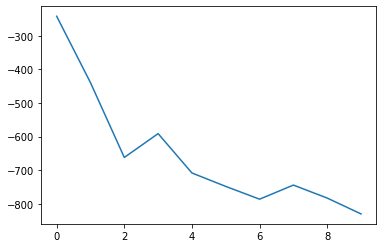

In [120]:
plt.plot(rewards);

In [121]:
np.mean([7,6,5,4,3,2,1,0])

3.5

In [122]:
out;

In [123]:
me = MazeEnvironment({})
obs = me.reset(seed=seed)
me.render()

P...X
.....
X...X
X....
....E


In [124]:
action = trainer.compute_single_action(input_dict={"obs": obs})
res = me.step(action)
obs = res[0]
me.render()

print("\naction:", action_names[action])
print("reward:", res[1])
print("done:", res[2])

P...X
.....
X...X
X....
....E

action: left
reward: -8
done: False


In [125]:
print(trainer.evaluation_workers)

In [126]:
trainer.evaluate()

{'evaluation': {'episode_reward_max': -4000.0,
  'episode_reward_min': -4000.0,
  'episode_reward_mean': -4000.0,
  'episode_len_mean': 500.0,
  'episode_media': {},
  'episodes_this_iter': 10,
  'policy_reward_min': {},
  'policy_reward_max': {},
  'policy_reward_mean': {},
  'custom_metrics': {},
  'hist_stats': {'episode_reward': [-4000.0,
    -4000.0,
    -4000.0,
    -4000.0,
    -4000.0,
    -4000.0,
    -4000.0,
    -4000.0,
    -4000.0,
    -4000.0],
   'episode_lengths': [500, 500, 500, 500, 500, 500, 500, 500, 500, 500]},
  'sampler_perf': {'mean_raw_obs_processing_ms': 0.029206347451212884,
   'mean_inference_ms': 0.2329568342312983,
   'mean_action_processing_ms': 0.01354766735861812,
   'mean_env_wait_ms': 0.015725185575067604,
   'mean_env_render_ms': 0.0},
  'off_policy_estimator': {},
  'timesteps_this_iter': 0}}

In [127]:
policy = trainer.get_policy()
model = policy.model

In [128]:
from ray.rllib.models.preprocessors import get_preprocessor 
obs_space = me.observation_space
preprocessor = get_preprocessor(obs_space)(obs_space)
observations = me.reset()
transformed = preprocessor.transform(observations).reshape(1, -1)

In [130]:
model;

In [131]:
model_output, _ = model({"obs": transformed})

AttributeError: 'numpy.ndarray' object has no attribute 'float'

In [102]:
model_output

<tf.Tensor 'model/fc_out/Tanh:0' shape=(1, 256) dtype=float32>

In [103]:
q_values = model.get_q_value_distributions(model_output)

In [113]:
tf.print(q_values[1])

name: "PrintV2_2"
op: "PrintV2"
input: "StringFormat_2"
attr {
  key: "end"
  value {
    s: "\n"
  }
}
attr {
  key: "output_stream"
  value {
    s: "stderr"
  }
}



In [106]:
action_distribution = policy.dist_class(model_output, model) 
sample = action_distribution.sample()
print(sample)

Tensor("Squeeze:0", shape=(1,), dtype=int64)
